# $\fbox{4-3}$ 予測精度の評価 ~ 混同行列と性能評価指標

## 識別モデルの分類と予測精度評価指標


## 混同行列


## 性能評価指標


### Accuracy（正解率）


### Sensitivity（感度）・ Recall（再現率）


### Specificity（特異度）


### PPV（陽性的中率）・ Precision（適合率）


### NPV（陰性的中率）


### F-score（F値）


### 性能評価指標の計算


In [1]:
%matplotlib notebook

import gc
import math
import pickle

# 本書 4 章の関数群を含む自作ライブラリ
import mylibs.mylib4 as mylib4

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

pd.options.display.max_rows = 6
pd.options.display.max_columns = 12

In [2]:
def load_bases():
    # Load dict_bp
    f = open('./pseudo_medical/processed/incl_bp/dict_bp.binaryfile', 'rb')  # rb: Read Binary
    dict_bp = pickle.load(f)
    f.close()
    # Load opt_result
    f = open('./pseudo_medical/processed/incl_bp/opt_result.binaryfile', 'rb')  # rb: Read Binary
    opt_result = pickle.load(f)
    f.close()
    # Load df_summary
    df_summary = pd.read_csv('./pseudo_medical/processed/incl_bp/df_summary_with_CI.csv')
    return (dict_bp, opt_result, df_summary)


(dict_bp, opt_result, df_summary) = load_bases()

In [3]:
sex, x = 'M', 60

dict_bp[sex]['exp']['class'][x]

array([2.0, 3.0, 3.0, ..., 4.0, 4.0, 4.0], dtype=object)

In [4]:
w = opt_result.x[0]
w

0.33310546874999997

In [5]:
mylib4.get_baseline(df_summary, sex, x)

0.007994495266910163

In [6]:
def predict_rate(df_summary, dict_bp, w, exp_or_out, sex, x):
    baseline = mylib4.get_baseline(df_summary, sex, x)
    bp_classes = dict_bp[sex][exp_or_out]['class'][x].astype('f8')
    return baseline * np.exp(w * bp_classes)


exp_or_out, sex, x = 'exp', 'M', 60
predict_rate(df_summary, dict_bp, w, exp_or_out, sex, x)

array([0.01556406, 0.02171644, 0.02171644, ..., 0.03030083, 0.03030083,
       0.03030083])

In [7]:
def TP(df_summary, dict_bp, w, sex, x):
    rates = predict_rate(df_summary, dict_bp, w, 'out', sex, x)
    return rates.sum()


def FP(df_summary, dict_bp, w, sex, x):
    rates_exp = predict_rate(df_summary, dict_bp, w, 'exp', sex, x)
    return rates_exp.sum() - TP(df_summary, dict_bp, w, sex, x)
    
    
def FN(df_summary, dict_bp, w, sex, x):
    rates = predict_rate(df_summary, dict_bp, w, 'out', sex, x)
    return len(rates) - rates.sum()


def TN(df_summary, dict_bp, w, sex, x):
    exp = len(predict_rate(df_summary, dict_bp, w, 'exp', sex, x))
    tn = exp - TP(df_summary, dict_bp, w, sex, x) - FP(df_summary, dict_bp, w, sex, x) - FN(df_summary, dict_bp, w, sex, x)
    return tn


tp = TP(df_summary, dict_bp, w, sex, x)
fp = FP(df_summary, dict_bp, w, sex, x)
fn = FN(df_summary, dict_bp, w, sex, x)
tn = TN(df_summary, dict_bp, w, sex, x)
exp = len(predict_rate(df_summary, dict_bp, w, 'exp', sex, x))

print(tp, fp, fn, tn)
print(tp + fp + fn + tn, exp)

0.4480081341366288 22.55199186586337 22.55199186586337 1219.4480081341367
1265.0 1265


In [8]:
dict_confusion = {'M':{}, 'F':{}}
for sex in ['M', 'F']:
    for x in np.arange(65):
        dict_confusion[sex][x] = {}
        dict_confusion[sex][x]['TP'] = TP(df_summary, dict_bp, w, sex, x)
        dict_confusion[sex][x]['FP'] = FP(df_summary, dict_bp, w, sex, x)
        dict_confusion[sex][x]['FN'] = FN(df_summary, dict_bp, w, sex, x)
        dict_confusion[sex][x]['TN'] = TN(df_summary, dict_bp, w, sex, x)

In [9]:
for sex in ['M', 'F']:
    for x in np.arange(65):
        tp = dict_confusion[sex][x]['TP']
        fp = dict_confusion[sex][x]['FP']
        fn = dict_confusion[sex][x]['FN']
        tn = dict_confusion[sex][x]['TN']
        n = tp + fp + fn + tn
        dict_confusion[sex][x]['TP_ratio'] = tp / n
        dict_confusion[sex][x]['FP_ratio'] = fp / n
        dict_confusion[sex][x]['FN_ratio'] = fn / n
        dict_confusion[sex][x]['TN_ratio'] = tn / n

In [10]:
def accuracy(dict_confusion, sex, x):
    tp = dict_confusion[sex][x]['TP']
    fp = dict_confusion[sex][x]['FP']
    fn = dict_confusion[sex][x]['FN']
    tn = dict_confusion[sex][x]['TN']
    if (tp + fp + fn + tn) > 0:
        return (tp + tn) / (tp + fp + fn + tn)
    else:
        return None

In [11]:
def sensitivity(dict_confusion, sex, x):
    tp = dict_confusion[sex][x]['TP']
    fn = dict_confusion[sex][x]['FN']
    if (tp + fn) > 0:
        return tp / (tp + fn)
    else:
        return None

In [12]:
def specificity(dict_confusion, sex, x):
    fp = dict_confusion[sex][x]['FP']
    tn = dict_confusion[sex][x]['TN']
    if (fp + tn) > 0:
        return tn / (fp + tn)
    else:
        return None

In [13]:
def PPV(dict_confusion, sex, x):
    tp = dict_confusion[sex][x]['TP']
    fp = dict_confusion[sex][x]['FP']
    if (tp + fp) > 0:
        return tp / (tp + fp)
    else:
        return None

In [14]:
def NPV(dict_confusion, sex, x):
    fn = dict_confusion[sex][x]['FN']
    tn = dict_confusion[sex][x]['TN']
    if (fn + tn) > 0:
        return tn / (fn + tn)
    else:
        return None

In [15]:
def Fscore(dict_confusion, sex, x):
    tp = dict_confusion[sex][x]['TP']
    fp = dict_confusion[sex][x]['FP']
    fn = dict_confusion[sex][x]['FN']
    if (2 * tp + fn + fp) > 0:
        return 2 * tp / (2 * tp + fn + fp)
    else:
        return None

In [16]:
for sex in ['M', 'F']:
    for x in np.arange(65):
        dict_confusion[sex][x]['accuracy'] = accuracy(dict_confusion, sex, x)
        dict_confusion[sex][x]['sensitivity'] = sensitivity(dict_confusion, sex, x)
        dict_confusion[sex][x]['specificity'] = specificity(dict_confusion, sex, x)
        dict_confusion[sex][x]['PPV'] = PPV(dict_confusion, sex, x)
        dict_confusion[sex][x]['NPV'] = NPV(dict_confusion, sex, x)
        dict_confusion[sex][x]['Fscore'] = Fscore(dict_confusion, sex, x)

In [17]:
dict_confusion['M'][60]

{'TP': 0.4480081341366288,
 'FP': 22.55199186586337,
 'FN': 22.55199186586337,
 'TN': 1219.4480081341367,
 'TP_ratio': 0.0003541566277759912,
 'FP_ratio': 0.017827661554042192,
 'FN_ratio': 0.017827661554042192,
 'TN_ratio': 0.9639905202641397,
 'accuracy': 0.9643446768919157,
 'sensitivity': 0.019478614527679513,
 'specificity': 0.9818421965653275,
 'PPV': 0.019478614527679513,
 'NPV': 0.9818421965653275,
 'Fscore': 0.019478614527679513}

In [18]:
def get_values(dict_confusion, sex, indicator):
    values = []
    for x in np.arange(65):
        values.append(dict_confusion[sex][x][indicator])
    return values


sex, indicator = 'M', 'accuracy'
get_values(dict_confusion, sex, indicator)[:5]

[0.9811044473641141,
 0.9970524712099581,
 0.9825708584112463,
 0.9913957464645334,
 0.9935876705441492]

In [19]:
def plot_indicator(ax, dict_confusion, indicator):
    X = np.arange(65)
    Y = get_values(dict_confusion, 'M', indicator)
    ax.plot(X, Y, c='b', label='Male')
    Y = get_values(dict_confusion, 'F', indicator)
    ax.plot(X, Y, c='r', label='Female')
    ax.set_title(indicator)
    ax.legend(loc='best')
    ax.set_xlabel('Age')
    return ax

<IPython.core.display.Javascript object>


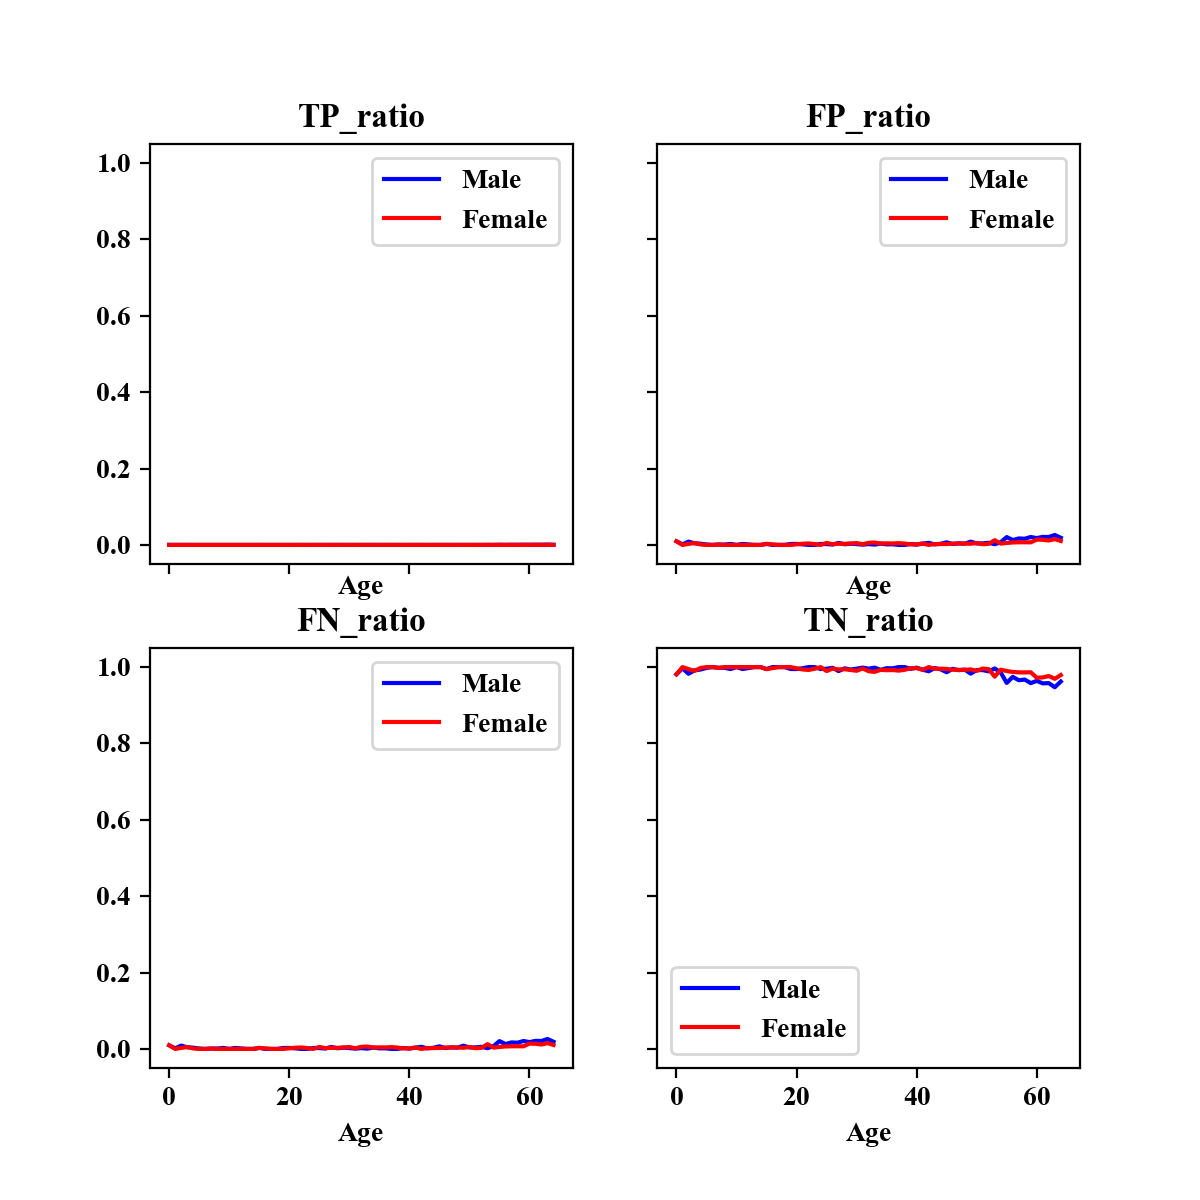

In [20]:
fig = plt.figure(figsize=(6, 6))
axes = fig.subplots(2, 2, sharex=True, sharey=True)
axes[0][0] = plot_indicator(axes[0][0], dict_confusion, 'TP_ratio')
axes[0][1] = plot_indicator(axes[0][1], dict_confusion, 'FP_ratio')
axes[1][0] = plot_indicator(axes[1][0], dict_confusion, 'FN_ratio')
axes[1][1] = plot_indicator(axes[1][1], dict_confusion, 'TN_ratio')

<IPython.core.display.Javascript object>


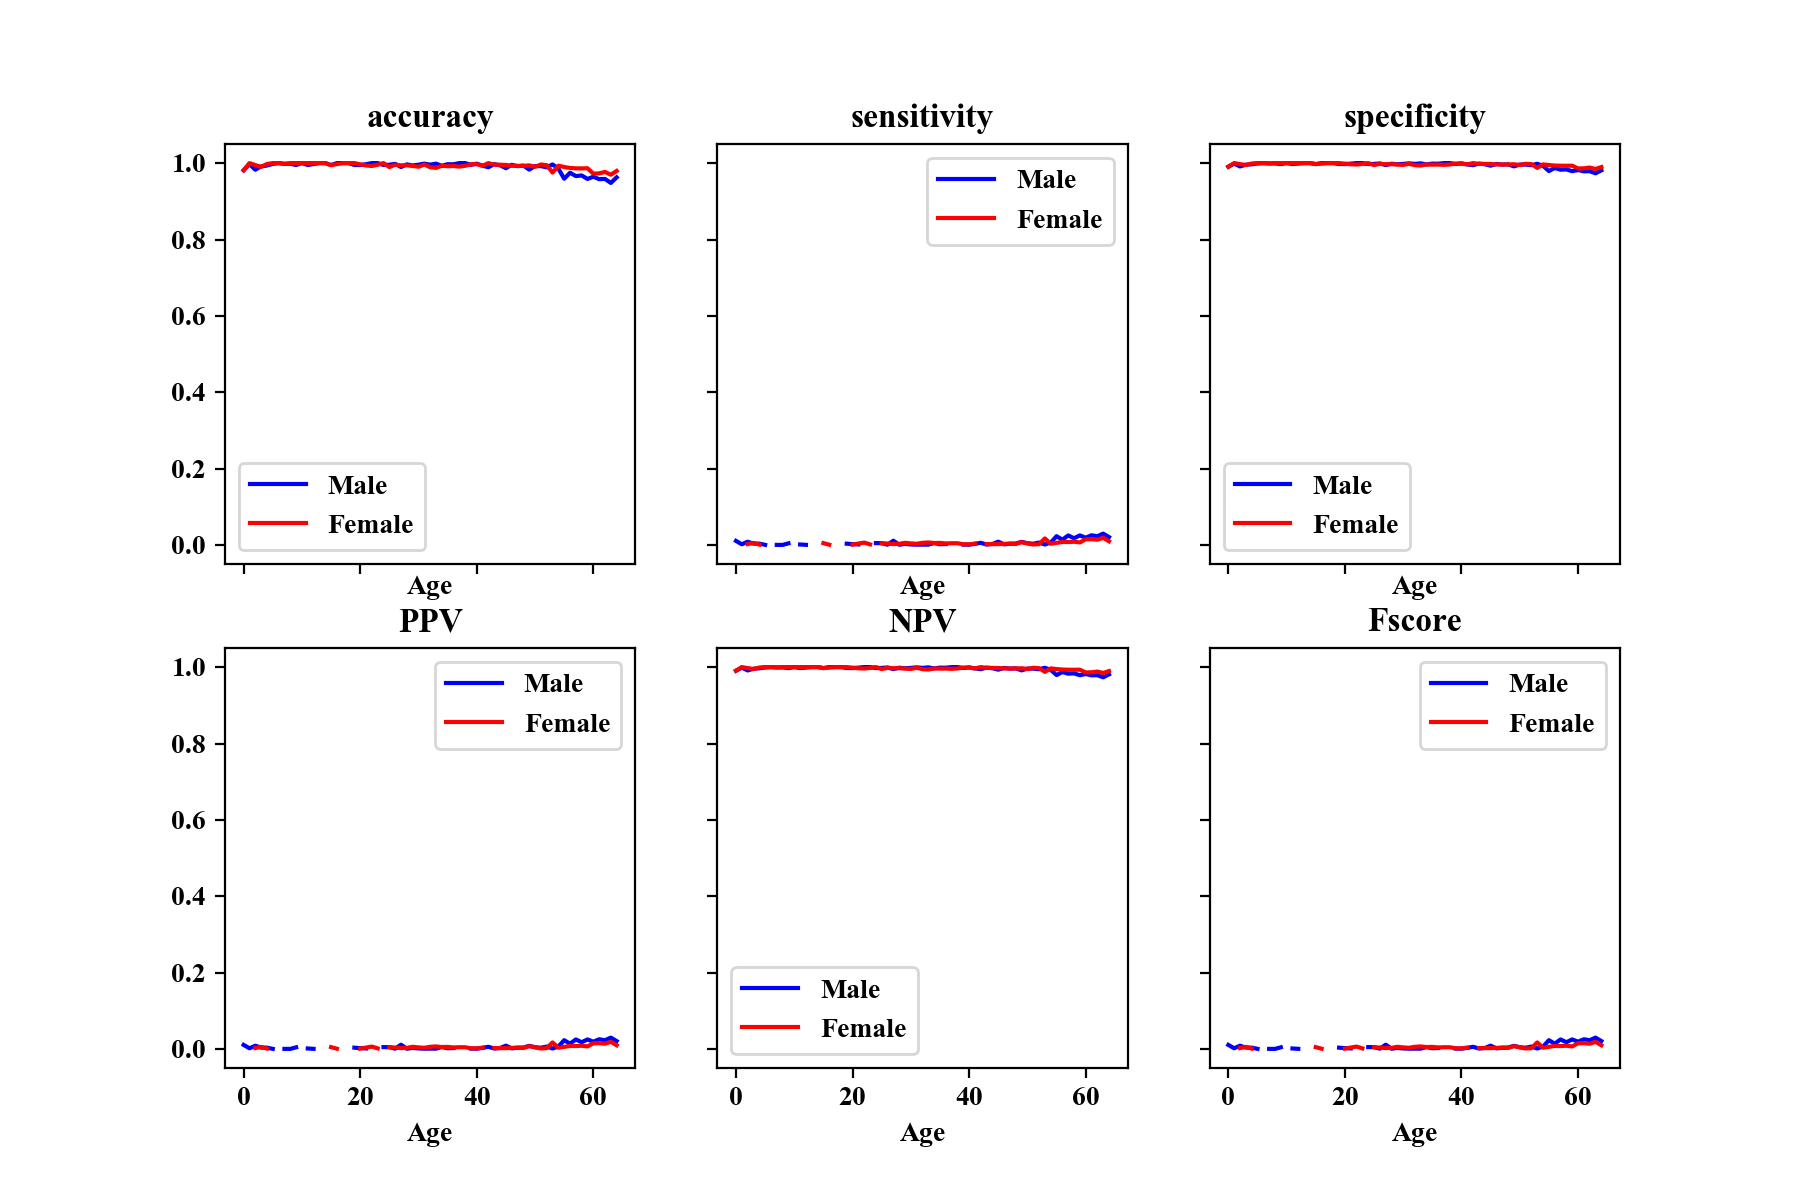

In [21]:
fig = plt.figure(figsize=(9, 6))
axes = fig.subplots(2, 3, sharex=True, sharey=True)
axes[0][0] = plot_indicator(axes[0][0], dict_confusion, 'accuracy')
axes[0][1] = plot_indicator(axes[0][1], dict_confusion, 'sensitivity')
axes[0][2] = plot_indicator(axes[0][2], dict_confusion, 'specificity')
axes[1][0] = plot_indicator(axes[1][0], dict_confusion, 'PPV')
axes[1][1] = plot_indicator(axes[1][1], dict_confusion, 'NPV')
axes[1][2] = plot_indicator(axes[1][2], dict_confusion, 'Fscore')

## まとめ